# XGBoost 

In de data analyse is er gebruik gemaakt van kNN regressie. De resultaten zijn beperkt, ik kreeg de hint om eens naar [XGBoost](https://xgboost.readthedocs.io/en/stable/) te kijken. Dit document is mijn eigen gemaakte referentie voor het gebruik van XGBoost.

De welbekende _boston_ dataset wordt gebruikt. Ieder code blok kan op zichzelf uitgevoerd worden. Eerst wordt kNN gebruikt, om als baseline te dienen. Om de nauwkeurigheid van het model te vergelijken wordt de RMSE gebruikt. 

In [1]:
import xgboost as xgb

print(xgb.__version__)

/home/paulschouten/Documents/bit-academy/data-engineer-eindopdracht/venv/lib64/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


1.5.2


Linkjes naar gelezen artikelen

- https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
- https://machinelearningmastery.com/xgboost-for-regression/
- https://stackoverflow.com/questions/34469038/understanding-python-xgboost-cv
- https://stackoverflow.com/questions/68766331/how-to-apply-predict-to-xgboost-cross-validation
- https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
- https://towardsdatascience.com/xgboost-python-example-42777d01001e
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://xgboost.readthedocs.io/en/latest/python/python_api.html
- https://xgboost.readthedocs.io/en/latest/python/python_intro.html


In [2]:
# Vergelijken met knn regressor,
# zelfde data set, standaard (niet geoptimaliseerde kNN)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
from sklearn.model_selection import train_test_split

# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = pd.read_csv(url, header=None)
data = dataframe.values
# split data into input and output columns
X, y = data[:, :-1], data[:, -1]

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

# kNN model opstarten, met standaard parameters
knn_model = KNeighborsRegressor()

# Data fitten aan model
knn_model.fit(X_train, y_train)

# Afwijking t.o.v. model uitrekenen
# Check RMSE prediction for train set
pred = knn_model.predict(X_train)
print(f'RMSE train: {sqrt(mean_squared_error(y_train, pred)):.2f}')

# Check RMSE for test set
pred = knn_model.predict(X_test)
print(f'RMSE test: {sqrt(mean_squared_error(y_test, pred)):.2f}') 

# Resultaat en benchmark:
# RMSE train: 5.12
# RMSE test: 7.51

RMSE train: 4.81
RMSE test: 6.90


In [3]:
# XGBoost
# Regressie met XGBoost, zonder optimalisaties

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pprint

# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = pd.read_csv(url, header=None)
data = dataframe.values

# split data into input and output columns
X, y = data[:, :-1], data[:, -1]

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Learning API uses a dmatrix
dmatrix = xgb.DMatrix(data=X_train, label=y_train) 

# Parameters for training model
params = {'objective':'reg:squarederror'}

# Train model with parameters and
# look at 'rmse' (minimize)
# maximum 250 rounds
# stop when result does not improve in 3 opeenvolgende iteraties
trained_model = xgb.train(params=params,
                          dtrain=dmatrix,
                          evals=[(dmatrix, 'rmse')],
                          verbose_eval=25,
                          num_boost_round=1000,
                          early_stopping_rounds=5)

print(f'num rounds: {trained_model.num_boosted_rounds()}')

# Check RMSE prediction for train set
pred = trained_model.predict(xgb.DMatrix(data=X_train))
print(f'RMSE train: {sqrt(mean_squared_error(y_train, pred)):.2f}')

# Check RMSE for test set
pred = trained_model.predict(xgb.DMatrix(data=X_test))
print(f'RMSE test: {sqrt(mean_squared_error(y_test, pred)):.2f}')  

# Resultaat:
# RMSE train: 0.00
# RMSE test: 2.75

# Dit is een verbetering t.o.v. kNN non-optimized

[0]	rmse-rmse:17.20572
[25]	rmse-rmse:0.48609
[50]	rmse-rmse:0.12196
[75]	rmse-rmse:0.04135
[100]	rmse-rmse:0.01256
[125]	rmse-rmse:0.00551
[150]	rmse-rmse:0.00243
[170]	rmse-rmse:0.00118
num rounds: 171
RMSE train: 0.00
RMSE test: 2.63


In [4]:
# Optimaliseren van parameters voor XGBoost
# Kijken naar zowel een train als een test set
# In de bovenste twee komt iedere keer een 

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pprint
from itertools import product
import time

# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = pd.read_csv(url, header=None)
data = dataframe.values

# split data into input and output columns
X, y = data[:, :-1], data[:, -1]

# Learning API uses a dmatrix
dmatrix = xgb.DMatrix(data=X, label=y) 


# Functie die model met parameters x[...] uitvoert.
# met CrossValidation wordt het model getraind en
# geëvalueerd. Het resultaat wordt weer teruggegeven
def fit(x):
    # Parameters for training model
    params = {'objective':'reg:squarederror',
              'eval_metric':'rmse',
              'eta': x[0],
              'gamma': x[1],
              'max_depth': int(x[2]),
              'tree_method': 'auto'}
    
    print(f'Testing: {params}') 
    
    # Cross validation uitvoeren,
    # Het model splitst de data in _nfold_ delen op
    # en traint en valideert over ieder stuk
    xgb_cv = xgb.cv(dtrain=dmatrix, 
                    params=params, 
                    nfold=5, 
                    metrics = 'rmse',
                    num_boost_round=500,
                    early_stopping_rounds=3,
                    verbose_eval=25,
                    seed=42)
    
    # Return de laatste regel
    return xgb_cv[-1:].values[0]

# Maak een search grid, itertools.product van welke waarden voor welke items
# - eta aka learning_rate: kleinere stappen voorkomt overfitting, range: 0-1 (0.3)
# - gamma aks min_split_loss: minimum wat een split aan verbetering moet geven, range: 0--> inf (0)
# - max_depth: maximum diepte van de tree te groot is risico overfitting, range 0--> inf (6)
# Dit zijn de eerste 3 parameters van xgboost:
# https://xgboost.readthedocs.io/en/stable/parameter.html

# 1e run: beste fit met gamma = 0
# grid = pd.DataFrame(product([0.1, 0.3, 0.5], [0, 1, 10], [3, 6, 10]), columns=['eta', 'gamma', 'max_depth'])
# 2e run: gamma=0, meer stapjes in eta
grid = pd.DataFrame(product([0.09, 0.1, 0.11, 0.12], [0], [6, 9, 10]), columns=['eta', 'gamma', 'max_depth'])

# Voor iedere regel in _grid_ (setje aan parameters) de _fit_ functie aanroepen
time_start = time.time()
grid[['train-mean','train-std', 'test-mean','test-std']] = grid.apply(fit, axis=1, result_type='expand')
time_done = time.time()

print(f"\nBeste test: \n{grid[grid['test-mean'] == grid['test-mean'].min()]}")
print(f"\nBeste train: \n{grid[grid['train-mean'] == grid['train-mean'].min()]}")

print(f'Tijd nodig: {(time_done - time_start):.1f} sec')
# resultaten laten zien
grid

# Resultaat:
# Beste test: 
#      eta  gamma  max_depth  train-mean  train-std  test-mean  test-std
# 11  0.11      0          8    0.218135   0.017302   2.798545  0.281566

# Beste train: 
#    eta  gamma  max_depth  train-mean  train-std  test-mean  test-std
# 8  0.1      0          8    0.209063   0.019136   2.861639  0.296443

# Met cross-validation wordt geen RMSE van 0 behaald. Logisch, want
# de train en test set veranderen iedere keer, het gemiddelde wordt
# per run teruggegeven. Maar dit levert wel een reëeler beeld op!
# De resultaten van niet dan wel met andere parameters zijn zo gering,
# en beter dan kNN, dat XGBoost zonder aanpassingen in de parameters
# gebruikt gaat worden in data_analyse

Testing: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.09, 'gamma': 0.0, 'max_depth': 6, 'tree_method': 'auto'}
[0]	train-rmse:21.83199+0.21056	test-rmse:21.82576+0.81894
[25]	train-rmse:2.90900+0.04514	test-rmse:3.96372+0.17661
[50]	train-rmse:1.03630+0.04736	test-rmse:2.97992+0.25602
[75]	train-rmse:0.67903+0.04425	test-rmse:2.89418+0.28292
[93]	train-rmse:0.50797+0.03109	test-rmse:2.88199+0.28760
Testing: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.09, 'gamma': 0.0, 'max_depth': 9, 'tree_method': 'auto'}
[0]	train-rmse:21.83199+0.21056	test-rmse:21.82576+0.81894
[25]	train-rmse:2.82219+0.03534	test-rmse:4.00241+0.18855
[50]	train-rmse:0.63851+0.02914	test-rmse:2.94241+0.26582
[75]	train-rmse:0.25535+0.02021	test-rmse:2.85930+0.27715
[81]	train-rmse:0.21296+0.01831	test-rmse:2.85911+0.27915
Testing: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.09, 'gamma': 0.0, 'max_depth': 10, 'tree_method': 'auto'}
[0]	train-rmse:21.831

,eta,gamma,max_depth,train-mean,train-std,test-mean,test-std
0,0.09,0,6,0.531229,0.031968,2.881192,0.286132
1,0.09,0,9,0.232809,0.019083,2.858804,0.278092
2,0.09,0,10,0.232604,0.017438,2.888051,0.290183
3,0.10,0,6,0.449017,0.036690,2.816967,0.274806
4,0.10,0,9,0.117955,0.012746,2.818196,0.300336
5,0.10,0,10,0.224259,0.017402,2.823898,0.265988
6,0.11,0,6,0.659321,0.032383,2.858012,0.354274
7,0.11,0,9,0.090099,0.006102,2.782645,0.290449
8,0.11,0,10,0.070387,0.011347,2.780098,0.284559
9,0.12,0,6,0.637339,0.027123,2.825865,0.383539


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

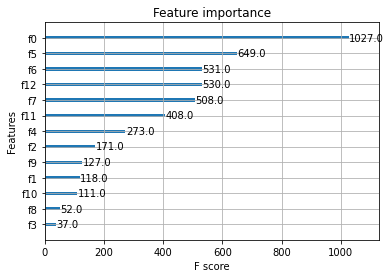

In [5]:
# Laten zien welke parameters het belangrijkste (meetst voorkomende) in het model zijn
xgb.plot_importance(trained_model)